In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# For local storage.
DATA_FOLDER = 'data/'
DATAFRAME_FILE = DATA_FOLDER + 'cleaned_data.pkl'

In [3]:
current_dir = Path.cwd()
frame_path = current_dir.joinpath(DATAFRAME_FILE)
shots_df = pd.read_pickle(str(frame_path))

In [4]:
pd.set_option('display.max_columns', None)
shots_df.head()

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,secondary_type,event_coord_x,event_coord_y,is_rebound,shot_dist,calc_dist,dist_difference,result,is_goal
0,2018020001,20182019,False,Scotiabank Arena,MTL,TOR,False,1,29,False,1171,EV,0,0,0,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Backhand,Backhand,78.0,-19.0,False,22.0,21.954498,0.045502,Save,False
1,2018020001,20182019,False,Scotiabank Arena,TOR,MTL,True,1,49,False,1151,EV,0,0,0,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Snap,Snap Shot,37.0,10.0,False,52.0,52.952809,0.952809,Save,False
2,2018020001,20182019,False,Scotiabank Arena,MTL,TOR,False,1,60,False,1140,EV,0,0,0,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Wrist,Wrist Shot,47.0,-23.0,False,48.0,47.885280,0.114720,Save,False
5,2018020001,20182019,False,Scotiabank Arena,MTL,TOR,False,1,229,False,971,EV,0,0,0,MISS,6,5,3,6,5,3,False,False,Off. Zone,Snap,None,73.0,22.0,False,27.0,27.202941,0.202941,Wide of Net,False
6,2018020001,20182019,False,Scotiabank Arena,MTL,TOR,False,1,234,False,966,EV,0,0,0,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Snap,Snap Shot,53.0,14.0,False,39.0,38.626416,0.373584,Save,False


In [5]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118280 entries, 0 to 160031
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            118280 non-null  object 
 1   season             118280 non-null  object 
 2   is_playoff_game    118280 non-null  bool   
 3   venue              118280 non-null  object 
 4   att_code           118280 non-null  object 
 5   def_code           118280 non-null  object 
 6   is_home            118280 non-null  bool   
 7   period             118280 non-null  int64  
 8   cum_time_elapsed   118280 non-null  int64  
 9   is_overtime        118280 non-null  bool   
 10  seconds_remaining  118280 non-null  int64  
 11  strength           118280 non-null  object 
 12  att_score          118280 non-null  int32  
 13  def_score          118280 non-null  int32  
 14  lead_size          118280 non-null  int32  
 15  event              118280 non-null  object 
 16  at

Start with some sanity checks on the data. The majority of NHL games are 60 minutes long, with a sizable minority having an additional time for overtime. We would expect the median event time to be roughly 30 minutes into the game, which is true.

In [6]:
shots_df['cum_time_elapsed'].describe()

count    118280.000000
mean       1824.058717
std        1053.668382
min           0.000000
25%         920.000000
50%        1808.000000
75%        2719.000000
max        5477.000000
Name: cum_time_elapsed, dtype: float64

Likewise, most NHL periods are 20 minutes long. Only regular season overtimes are shorter, at 5 minutes. We would expect the median time remaining in a period to be about 10 minutes. This is again what we find.

In [7]:
shots_df['seconds_remaining'].describe()

count    118280.000000
mean        593.051530
std         347.601714
min           0.000000
25%         288.000000
50%         596.000000
75%         896.000000
max        1200.000000
Name: seconds_remaining, dtype: float64

Overtimes are sudden-death, where a single goal ends the game. Since overtimes will often not last the entire scheduled time, we would expect the median regular-season overtime event to take place with over 2:30 remaining and the median playoff overtime event to take place with over 10:00 remining.

In [8]:
# Regular season overtimes
shots_df[(shots_df['is_overtime']) & (~shots_df['is_playoff_game'])]['seconds_remaining'].describe()

count    1406.000000
mean      161.334282
std        83.273681
min         0.000000
25%        96.000000
50%       170.500000
75%       235.000000
max       295.000000
Name: seconds_remaining, dtype: float64

In [9]:
# Playoff overtimes
shots_df[(shots_df['is_overtime']) & (shots_df['is_playoff_game'])]['seconds_remaining'].describe()

count     294.000000
mean      760.914966
std       317.730803
min         1.000000
25%       548.000000
50%       857.500000
75%      1022.750000
max      1193.000000
Name: seconds_remaining, dtype: float64

### Players on Ice

The standard situation in ice hockey sees each team providing six players on the ice, usually consisting of one goaltender (or "goalie") and five other players (often called "skaters" or "attackers"). The attackers can be further divided into forwards and defense. In most situations, teams play three forwards with two players on defense. Generally, forwards focus on scoring goals while the defense focuses on preventing them. The only positional restriction is that teams are only allowed one goaltender at any one time. Teams are not required to have a goalie on the ice and in some situations will "pull" the goaltender for an extra attacker. 

If a player commits a penalty, the usual punishment is for that player to be removed from the ice for a fixed length of time. During that time, the team is unable to replace the player on the ice. Teams may be reduced to four players on the ice due to penalties, but no further. When one team has more players on the ice than the other, the team with the player advantage is said to be on a "power play". The other team is described as "short-handed". If teams have the same number of players on the ice, the teams are said to be at "even strength". If a team has pulled their goalie for an extra attacker, that doesn't change these labels.

Rules fix the number of players on the ice to be between four and six, with the most common situation being six. Since teams are allowed at most one goalie, the number of skaters is also fixed between three and six, most commonly five. Since there is no restriction on the number of forwards, there may be anywhere from zero to six forwards on the ice.

Examining the fields counting the players on the ice, it is easy to see that these conditions hold true for this data set.

In [10]:
player_count_columns = ['att_players', 'def_players', 'att_skaters', 'def_skaters', 'att_forwards', 'def_forwards'] 
shots_df[player_count_columns].describe()

,att_players,def_players,att_skaters,def_skaters,att_forwards,def_forwards
count,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000
mean,5.939527,5.826259,4.959710,4.832271,3.084173,2.860529
std,0.278203,0.418524,0.313196,0.427537,0.442879,0.444511
min,4.000000,4.000000,3.000000,3.000000,1.000000,1.000000
25%,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
50%,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
75%,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


Teams are usually at even strength. When penalties occur, teams that are on the power-play have a numerical advantage and generally try to press that for shot attempts. Short-handed teams can produce shot attempts, but these are comparatively rarer than attempts while on the power play. This is confirmed by examining the data frame.

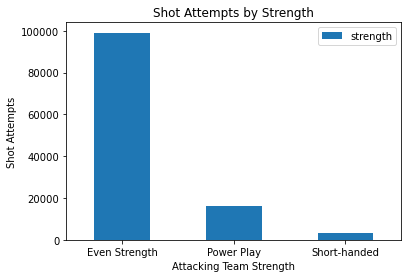

In [11]:
pd.DataFrame(shots_df['strength'].value_counts()) \
    .rename({'EV': 'Even Strength', 'PP': 'Power Play', 'SH': 'Short-handed'}) \
    .plot(kind='bar', xlabel='Attacking Team Strength', ylabel='Shot Attempts', title='Shot Attempts by Strength', rot=0);

Teams with more players on the ice tend to produce more shot attempts and these shots tend to be more successful. When comparing by number of players on the ice, this becomes apparent.

In [12]:
def create_pivot_players_on_ice(strength, pivot_col, aggfunc):
    col_def = 'def_' + pivot_col
    col_att = 'att_' + pivot_col
    if strength == 'ALL':
        pivot_df = shots_df
    else:
        pivot_df = shots_df[shots_df['strength']==strength]
    pivot_df = pivot_df.pivot_table(values='is_goal', index=col_def, columns=col_att, aggfunc=aggfunc, fill_value=0)
    pivot_df.columns.name = pivot_col.title() + ' (Attacking)'
    pivot_df.index.name = pivot_col.title() + ' (Defending)'
    return pivot_df

In [13]:
def create_heatmap_players_on_ice(strength, pivot_col, ax, fmt, title, aggfunc='count', palette='Reds', vmax=None, 
                                  font_scale=1, annot_size=12):
    df = create_pivot_players_on_ice(strength, pivot_col, aggfunc)
    mask = df==0
    sns.set(font_scale=font_scale)
    if (vmax is None):
        g = sns.heatmap(df, ax=ax, cmap=palette, annot=True, fmt=fmt, linewidth=0.5, mask=mask, vmin=0, 
                        annot_kws={"size": annot_size})
        g.set_facecolor('white')
    else:
        g = sns.heatmap(df, ax=ax, cmap=palette, annot=True, fmt=fmt, linewidth=0.5, mask=mask, vmin=0, vmax=vmax, 
                        annot_kws={"size": annot_size})
        g.set_facecolor('white')
    ax.set_title(title)

Interestingly, there are some situations which shouldn't be possible by definition. For even strength situations, players should have the same number of players on the ice. For power-play events, the attacking team should have more players on the ice. Conversely, when the attacker is short-handed, they should have fewer players. These turn out to be a small proportion of shot attempts however.

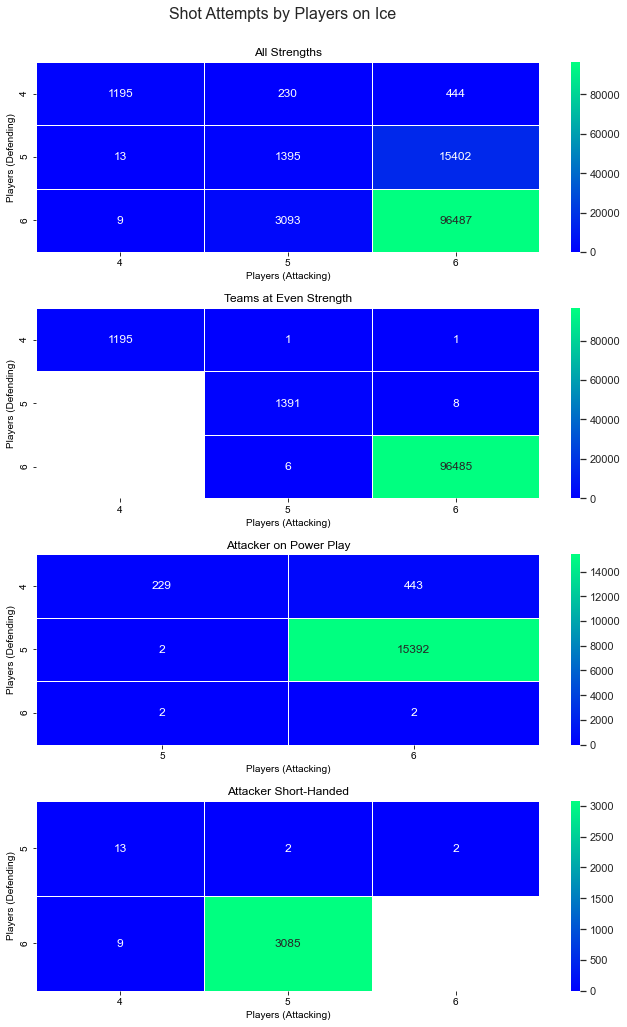

In [14]:
fig, axs = plt.subplots(4,1, figsize=(10,15));
palette='winter'
create_heatmap_players_on_ice('ALL', 'players', axs[0], '0.0f', 'All Strengths', 'count', palette)
create_heatmap_players_on_ice('EV', 'players', axs[1], '0.0f', 'Teams at Even Strength', 'count', palette)
create_heatmap_players_on_ice('PP', 'players', axs[2], '0.0f', 'Attacker on Power Play', 'count', palette)
create_heatmap_players_on_ice('SH', 'players', axs[3], '0.0f', 'Attacker Short-Handed', 'count', palette)
plt.suptitle('Shot Attempts by Players on Ice', fontsize=16, x=0.4)
fig.tight_layout(rect=[0, 0.03, 0.95, 0.98])

Unsuprisingly, shots are more likely to be successful when there are fewer defenders on the ice. As before, there are issues with situations which shouldn't be possible.

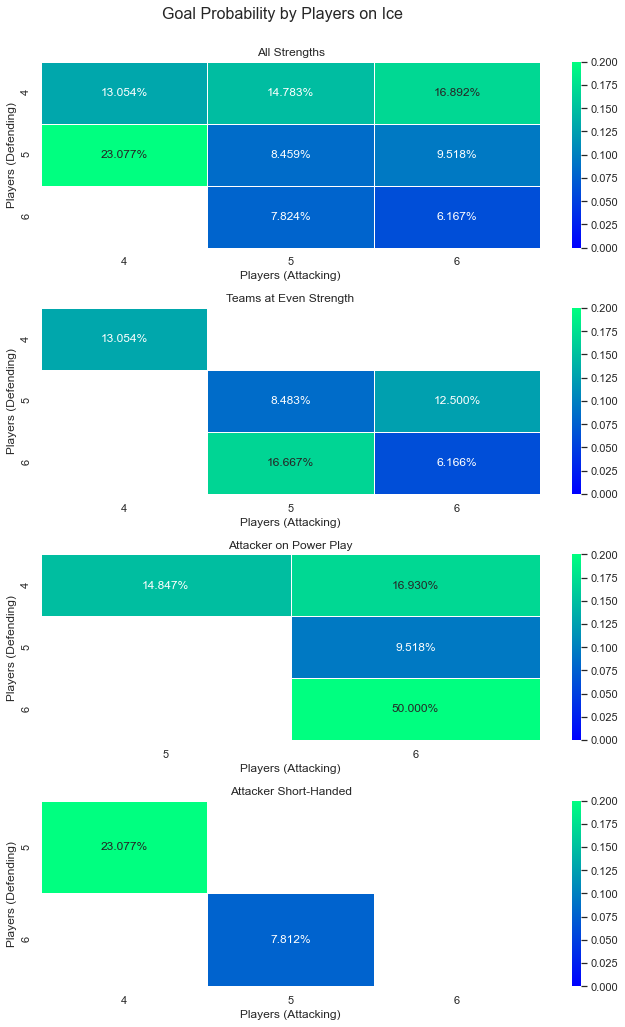

In [15]:
fig, axs = plt.subplots(4,1, figsize=(10,15));
palette='winter'
vmax = 0.2
create_heatmap_players_on_ice('ALL', 'players', axs[0], '0.3%', 'All Strengths', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('EV', 'players', axs[1], '0.3%', 'Teams at Even Strength', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('PP', 'players', axs[2], '0.3%', 'Attacker on Power Play', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('SH', 'players', axs[3], '0.3%', 'Attacker Short-Handed', 'mean', palette, vmax=vmax)
plt.suptitle('Goal Probability by Players on Ice', fontsize=16, x=0.4)
fig.tight_layout(rect=[0, 0.03, 0.95, 0.98])

Interestingly, there are some situations which shouldn't be definitionally possible. For even strength situations, players should have the same number of players on the ice. For power-play events, the attacking team should have more players on the ice. Conversely, when the attacker is short-handed, they should have fewer players.

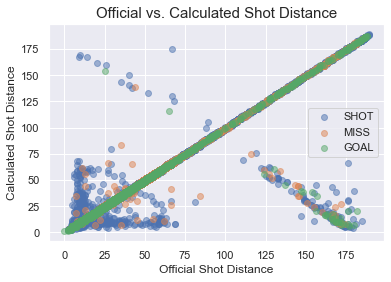

In [16]:
event_types = shots_df.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event==event_type], label=event_type, alpha=0.5);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance', fontsize=15);
plt.legend();

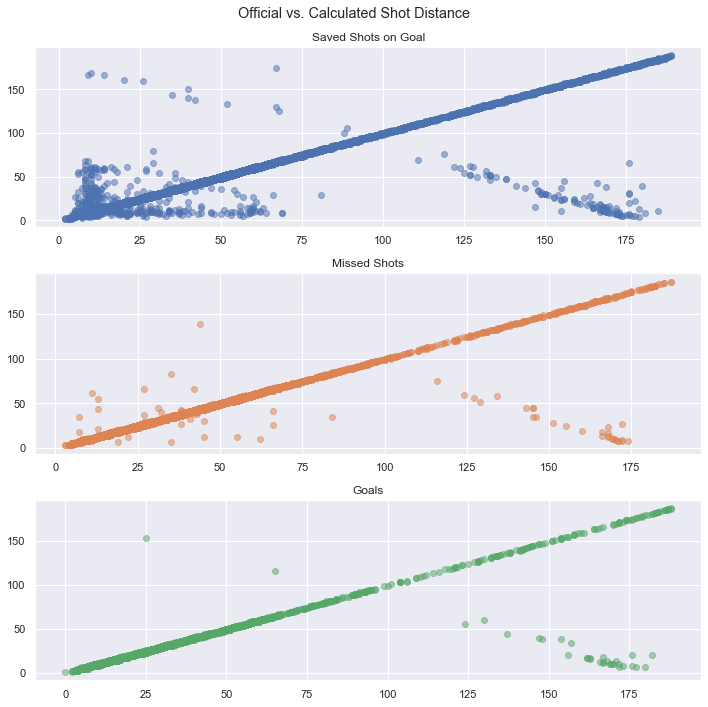

In [17]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
axs[0].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='SHOT'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='MISS'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='GOAL'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[2].set_title('Goals');
plt.suptitle('Official vs. Calculated Shot Distance');
fig.tight_layout()

There seems to be a systematic difference that can be seen in saves and missed shots that is separate from the mis-coding for attacking ends.

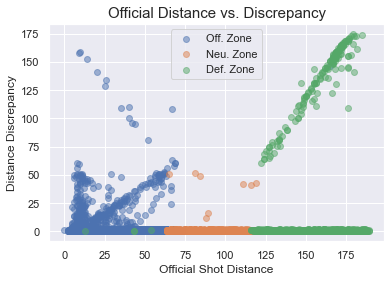

In [18]:
event_zones = shots_df.event_zone.unique()[:3]
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone==zone], label=zone, alpha=0.5);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy', fontsize=15);
plt.legend();

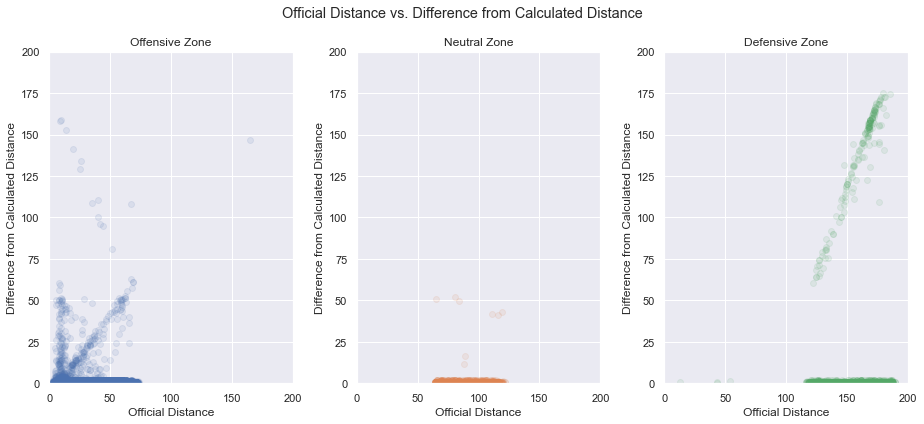

In [19]:
# Temporary
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Off. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Neu. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Def. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

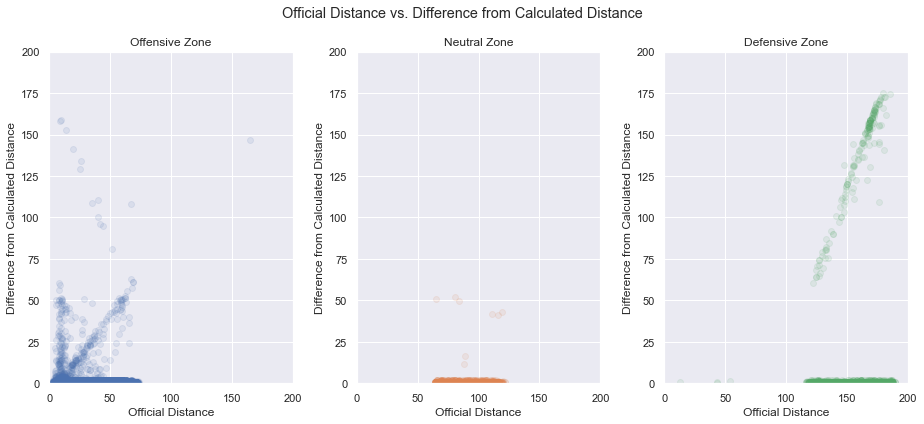

In [20]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Off. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Neu. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Def. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

No shots less than 60 feet from the goal can be correctly coded as defensive zone. There are a number of shots where coordinates and distance agree where the zone is obviously miscoded. This will be handled later.

There are two other patterns seen in the shots. The first is a line with slope near 1 in the offensive zone plot. The other is a near vertical-line associated with very short distance shots.

The offensive zone is the set of coordinates with $x$-coordinate of at least 25. The $y$-coordinate can vary between -42.5 and 42.5. Since the center of the goal is located at $(89,0)$, the longest possible shot in the offensive zone has length $\sqrt{(89-25)^2 + (42.5)^2} \approx 77$

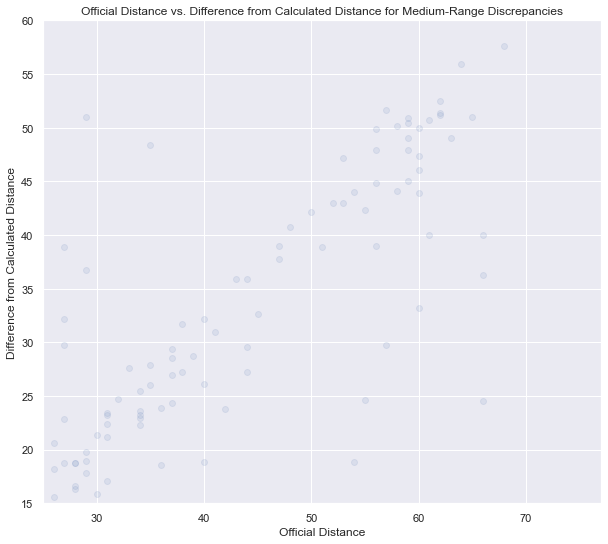

In [21]:
fig = plt.figure(figsize=(10,60))
plt.gca().set_aspect(aspect='equal')
plt.xlim(25,77);
plt.ylim(15,60);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist > 25) 
                                                                & (shots_df.shot_dist < 77) 
                                                                & (shots_df.dist_difference > 10)], alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Medium-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

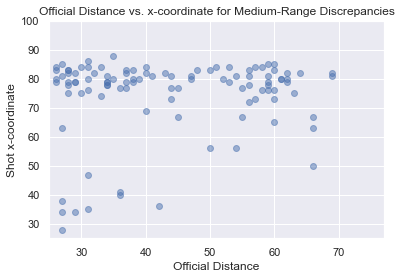

In [22]:
plt.xlim(25,77);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shots_df[(shots_df.shot_dist > 25) 
                                                              & (shots_df.shot_dist < 77) 
                                                              & (shots_df.dist_difference > 10)], alpha=0.5);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Medium-Range Discrepancies');

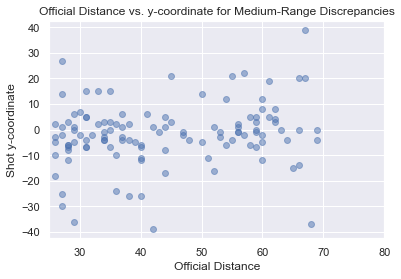

In [23]:
plt.xlim(25,80);
plt.ylim(-42.5, 42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shots_df[(shots_df.shot_dist > 25) 
                                                              & (shots_df.shot_dist < 77) 
                                                              & (shots_df.dist_difference > 10)], alpha=0.5);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Medium-Range Discrepancies');

Interestingly enough, most of the shots considered here seem to have coordinates near $x=80$ and $y=0$. This is just in front of the goal, which suggests that these might be shots which were found after-the-fact to have actually been deflected shots. This is a not-uncommon determination in the NHL, which results in an adjustment to the shooting player and distance in the statistics.

In [24]:
shots_df[(shots_df.shot_dist > 25) 
           & (shots_df.shot_dist < 77) 
           & (shots_df.dist_difference > 10)]['shot_type'].value_counts(normalize=True)

Wrist        0.594828
Slap         0.250000
Snap         0.120690
Tip-In       0.017241
Backhand     0.008621
Deflected    0.008621
Name: shot_type, dtype: float64

In [25]:
shots_df[(shots_df.shot_dist > 25) 
           & (shots_df.shot_dist < 77) 
           & (shots_df.dist_difference > 10)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.519608
Backhand       0.205882
Snap Shot      0.107843
Slap Shot      0.078431
Tip-In         0.039216
Deflected      0.029412
Wrap-around    0.019608
Name: secondary_type, dtype: float64

The category `secondary_type` is taken from the live feed, which is the data source which can be adjusted later. The category `shot_type` is extracted from the play-by-play. Notice that there are far more shots categorized as `Tip-In` or `Deflected` in the `secondary_type` column and far fewer `Slap` (`Slap Shot`) values. This suggests that this variation arises from post-game adjustment to the shot location. Additionally, this would suggest that the event-coordinates for these shots should be preferred.

Now, conduct a similar analysis for shots indicated at extremely short-range.

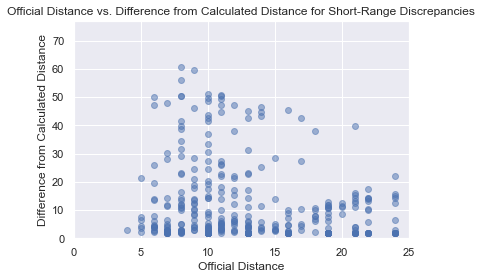

In [26]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist < 25)
                                                                & (shots_df.dist_difference >= 2)],alpha=0.5);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

Toward the bottom of this plot, it is possible to see the overlap with the preceding analysis. Consequently, the data will be replotted to exclude shots where the coordinates report short distances.

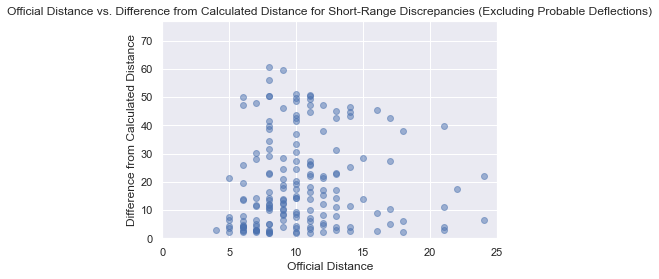

In [27]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist < 25)
                                                                & (shots_df.dist_difference >= 2)
                                                                & (shots_df.calc_dist > shots_df.shot_dist)],alpha=0.5);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies ' \
            + '(Excluding Probable Deflections)');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

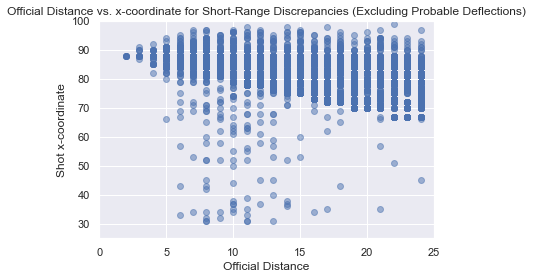

In [28]:
plt.xlim(0,25);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shots_df[(shots_df.shot_dist < 25) 
                                                              & (shots_df.shot_dist >= 2) 
                                                              & (shots_df.calc_dist > shots_df.shot_dist)], alpha=0.5);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

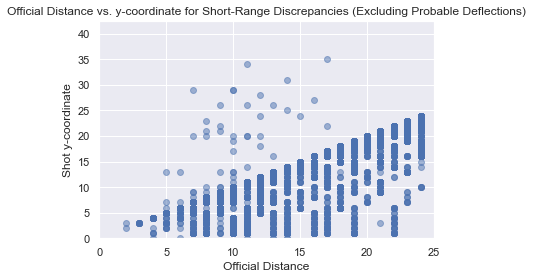

In [29]:
plt.xlim(0,25);
plt.ylim(0,42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shots_df[(shots_df.shot_dist < 25) 
                                                              & (shots_df.shot_dist >= 2) 
                                                              & (shots_df.calc_dist > shots_df.shot_dist)], alpha=0.5);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

In [30]:
shots_df[(shots_df.shot_dist < 25) 
           & (shots_df.shot_dist >= 2) 
           & (shots_df.calc_dist > shots_df.shot_dist)]['shot_type'].value_counts(normalize=True)

Wrist          0.518991
Backhand       0.186251
Snap           0.092878
Tip-In         0.086350
Wrap-around    0.060138
Deflected      0.036301
Slap           0.019090
Name: shot_type, dtype: float64

In [31]:
shots_df[(shots_df.shot_dist < 25) 
           & (shots_df.shot_dist >= 2) 
           & (shots_df.calc_dist > shots_df.shot_dist)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.541341
Backhand       0.178925
Snap Shot      0.098070
Tip-In         0.067032
Wrap-around    0.063641
Deflected      0.027517
Slap Shot      0.023474
Name: secondary_type, dtype: float64

While the trend isn't as prevalent as in the preceding analysis, there does appear to be a slight recategorization of shots away from deflected shots (`Tip-In` and `Deflected`). This may also indicate the result of post-game recoding of shots. Consequently, the coordinates will be used unchanged here.

Zone-miscoding still must be handled. Defensive zone shots are rare due to the length and the low-probability of scoring a goal. The working presumption should be that if the distances disagree, this is likely a consequence of a mis-coding which had one of the sources incorrectly mark the shot as coming from the defensive zone. This leads to the following.
1. Shots coded as the offensive zone: This zone coding is presumptively correct. Any coordinates which appear to place the shot outside of the offensive zone should be rotated to conform to this.
2. Shots coded as the neutral zone: There doesn't appear to be any common bias with these shots. Particularly there is no strong presumption for correctness of one set of data, so these shots will be left unchanged.
3. Shots coded as the defensive zone: This zone coding is presumptively incorrect. There is a considerable minority of shots which distance and coordinates seem to indicate actually took place in the offensive zone. These coordinates will be accepted as correct. For official shot distances which agree with being taken from the defensive zone, the coordinates will take precedence. This means that if the coordinates appear to indicate a shot from the offensive zone, these will be used instead.

The only listed category that requires adjustment to the coordinates are shots coded as offensive zone shots.

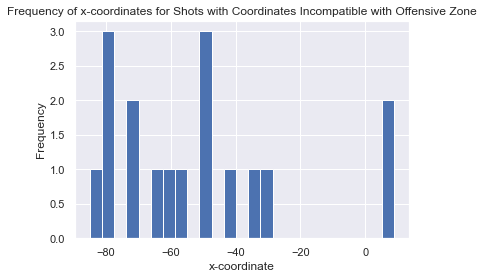

In [32]:
plt.hist(x='event_coord_x',data=shots_df[(shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < 25)], bins=25);
plt.xlabel('x-coordinate');
plt.ylabel('Frequency');
plt.title('Frequency of x-coordinates for Shots with Coordinates Incompatible with Offensive Zone');

In [33]:
shots_df[(shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < 25)]['event_coord_x'].describe()

count    17.000000
mean    -52.000000
std      27.622455
min     -85.000000
25%     -72.000000
50%     -55.000000
75%     -43.000000
max       9.000000
Name: event_coord_x, dtype: float64

Almost all of these shot attempts have $x$-coordinate less than $-25$. These shots would seem to be coming from the defensive zone. These are likely incorrect, and should be adjusted. Offensive zone shots with $x \leq -25$ will be adjusted.

In [34]:
adjusted_x = np.where((shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < -25), 
                      -shots_df.event_coord_x,
                      shots_df.event_coord_x)
adjusted_y = np.where((shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < -25), 
                      -shots_df.event_coord_y,
                      shots_df.event_coord_y)
shots_df['event_coord_x'] = adjusted_x
shots_df['event_coord_y'] = adjusted_y

In [35]:
shots_df['event_zone'].unique()

array(['Off. Zone', 'Neu. Zone', 'Def. Zone', nan], dtype=object)

In [36]:
def correct_zone(x):
    if (x <= -25):
        return 'Def. Zone'
    elif (x >= 25):
        return 'Off. Zone'
    elif x is None:
        return None
    else:
        return 'Neu. Zone'
shots_df['event_zone'] = shots_df.event_coord_x.apply(lambda x: correct_zone(x))

In [37]:
shots_df['event_zone'].unique()

array(['Off. Zone', 'Neu. Zone', 'Def. Zone'], dtype=object)

Since some coordinates were adjusted, the calculated distances need to be re-calculated.

In [38]:
shots_df['calc_dist'] = np.sqrt((shots_df['event_coord_x']-89)**2 + shots_df['event_coord_y']**2)
shots_df['dist_difference'] = np.abs(shots_df['calc_dist'] - shots_df['shot_dist'])

Re-examine the earlier analysis with these adjustments.

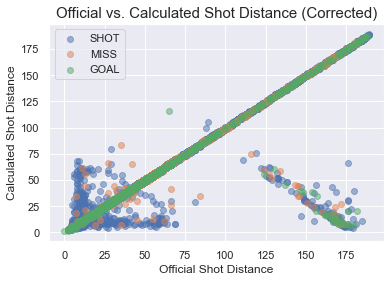

In [39]:
event_types = shots_df.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event==event_type], label=event_type, alpha=0.5);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance (Corrected)', fontsize=15);
plt.legend();

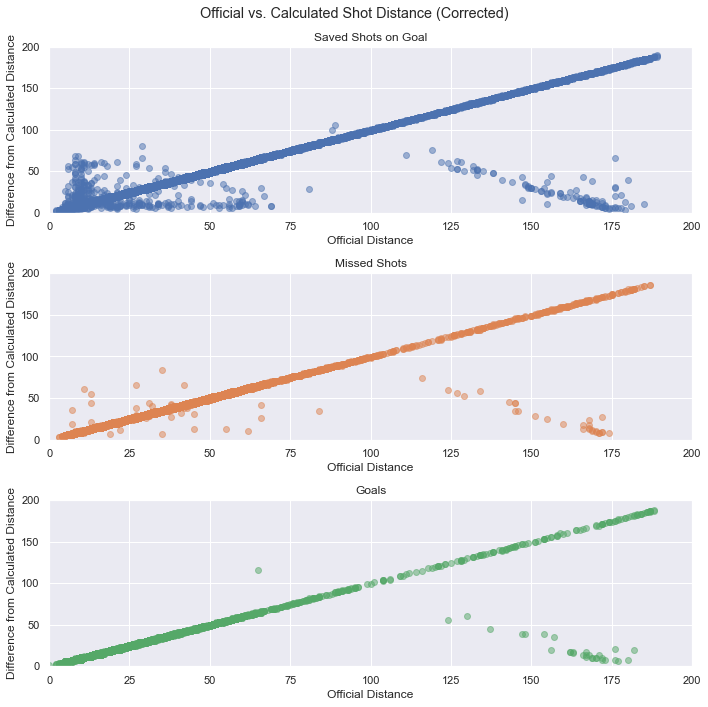

In [40]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='SHOT'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='MISS'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='GOAL'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[2].set_title('Goals');
plt.suptitle('Official vs. Calculated Shot Distance (Corrected)');
fig.tight_layout()

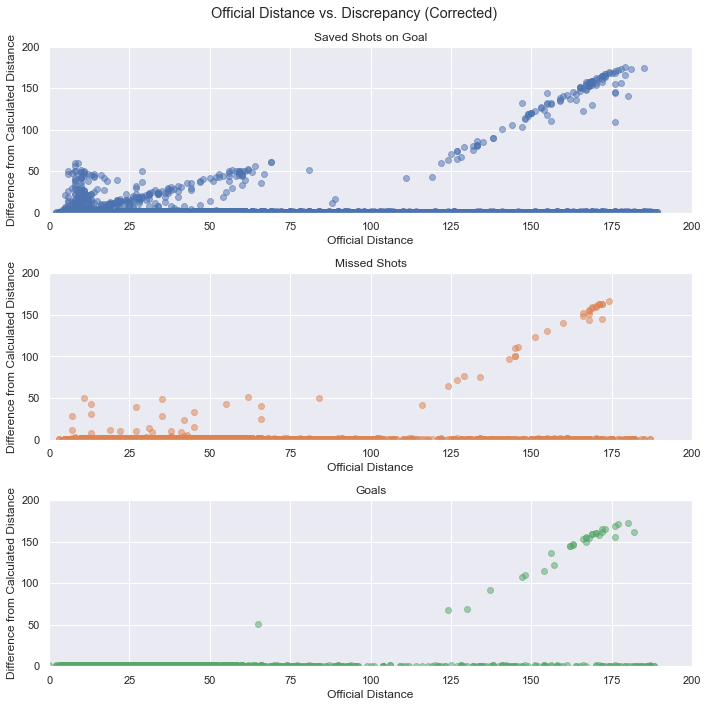

In [41]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='SHOT'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='MISS'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='GOAL'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[2].set_title('Goals');
plt.suptitle('Official Distance vs. Discrepancy (Corrected)');
fig.tight_layout()

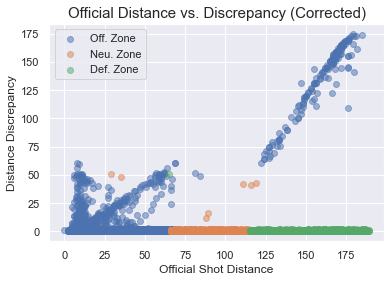

In [42]:
event_zones = shots_df.event_zone.unique()
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone==zone], label=zone, alpha=0.5);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy (Corrected)', fontsize=15);
plt.legend();

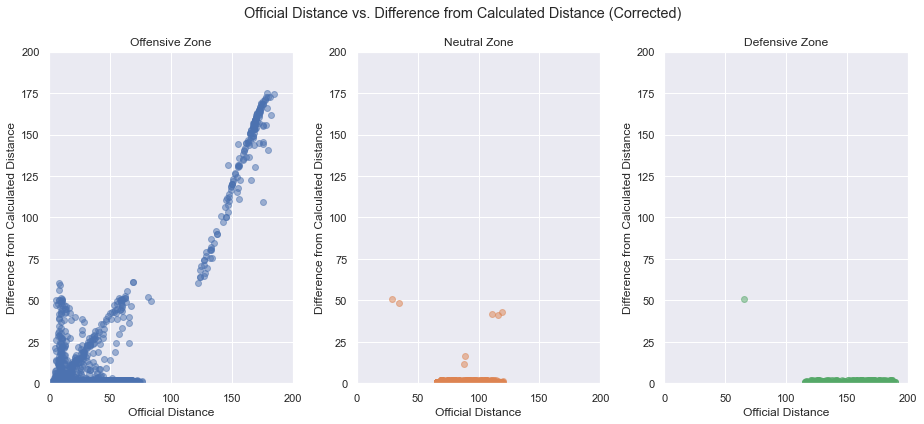

In [43]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Off. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Neu. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Def. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.5);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance (Corrected)');

fig.tight_layout()

The anomolies which were called out for correction seem to have largely disappeared. At this point, the `calc_dist` field is likely to be more accurate, so will be the only distance field retained. Likewise, `dist_difference` is no longer required

In [44]:
shots_df.drop(['shot_dist', 'dist_difference'], axis=1, inplace=True)

In [45]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118280 entries, 0 to 160031
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            118280 non-null  object 
 1   season             118280 non-null  object 
 2   is_playoff_game    118280 non-null  bool   
 3   venue              118280 non-null  object 
 4   att_code           118280 non-null  object 
 5   def_code           118280 non-null  object 
 6   is_home            118280 non-null  bool   
 7   period             118280 non-null  int64  
 8   cum_time_elapsed   118280 non-null  int64  
 9   is_overtime        118280 non-null  bool   
 10  seconds_remaining  118280 non-null  int64  
 11  strength           118280 non-null  object 
 12  att_score          118280 non-null  int32  
 13  def_score          118280 non-null  int32  
 14  lead_size          118280 non-null  int32  
 15  event              118280 non-null  object 
 16  at

The preceding analysis also provided reasons to believe that, while `secondary_type` and `shot_type` both provide shot-type information, `secondary_type` is likely to be more accurate when it is provided.

In [46]:
shot_types = np.where(shots_df.secondary_type.isna(), shots_df.shot_type, shots_df.secondary_type)
shots_df['shot_type'] = shot_types

In [47]:
shots_df.drop(['secondary_type'], axis=1, inplace=True)

In [48]:
shots_df['shot_type'].unique()

array(['Backhand', 'Snap Shot', 'Wrist Shot', 'Snap', 'Tip-In', 'Wrist',
       'Wrap-around', 'Slap Shot', 'Slap', 'Deflected', None, nan],
      dtype=object)

This introduced some duplication, as any type suffixed by `Shot` is the same as that type without the suffix. Additionally, the values with hyphens could create concerns later.

In [49]:
shot_types = {
    'Snap Shot': 'Snap',
    'Wrist Shot': 'Wrist',
    'Slap Shot': 'Slap',
    'Tip-In': 'Tip',
    'Wrap-around': 'Wrap',
}
shots_df['shot_type'].replace(shot_types, inplace=True)

In [50]:
shots_df['shot_type'].unique()

array(['Backhand', 'Snap', 'Wrist', 'Tip', 'Wrap', 'Slap', 'Deflected',
       None, nan], dtype=object)

In [51]:
shots_df['shot_type'].fillna(value='Unknown', inplace=True)

In [52]:
shots_df['shot_type'].unique()

array(['Backhand', 'Snap', 'Wrist', 'Tip', 'Wrap', 'Slap', 'Deflected',
       'Unknown'], dtype=object)

In [53]:
shots_df['shot_type'].value_counts()

Wrist        63044
Slap         18150
Snap         16075
Backhand      8947
Tip           7981
Deflected     2984
Wrap          1090
Unknown          9
Name: shot_type, dtype: int64

In [54]:
shots_df['shot_type'].describe()

count     118280
unique         8
top        Wrist
freq       63044
Name: shot_type, dtype: object

In [55]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118280 entries, 0 to 160031
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            118280 non-null  object 
 1   season             118280 non-null  object 
 2   is_playoff_game    118280 non-null  bool   
 3   venue              118280 non-null  object 
 4   att_code           118280 non-null  object 
 5   def_code           118280 non-null  object 
 6   is_home            118280 non-null  bool   
 7   period             118280 non-null  int64  
 8   cum_time_elapsed   118280 non-null  int64  
 9   is_overtime        118280 non-null  bool   
 10  seconds_remaining  118280 non-null  int64  
 11  strength           118280 non-null  object 
 12  att_score          118280 non-null  int32  
 13  def_score          118280 non-null  int32  
 14  lead_size          118280 non-null  int32  
 15  event              118280 non-null  object 
 16  at

In [56]:
shots_df.isna().sum()

game_id               0
season                0
is_playoff_game       0
venue                 0
att_code              0
def_code              0
is_home               0
period                0
cum_time_elapsed      0
is_overtime           0
seconds_remaining     0
strength              0
att_score             0
def_score             0
lead_size             0
event                 0
att_players          12
att_skaters          12
att_forwards         12
def_players          12
def_skaters          12
def_forwards         12
is_extra_attacker     0
is_empty_net          0
event_zone            0
shot_type             0
event_coord_x         3
event_coord_y         2
is_rebound            0
calc_dist             4
result                0
is_goal               0
dtype: int64

All of the player count categories correspond to each other, as these were intentionally made null earlier. This leaves the coordinate categories. A quick check shows that `calc_dist` is null if and only if one of the coordinate categories is null. The coordinate categories will be imputed with the median later.

In [57]:
shots_df[shots_df.event_coord_x.isna() | shots_df.event_coord_y.isna()].calc_dist.isna().sum()

4

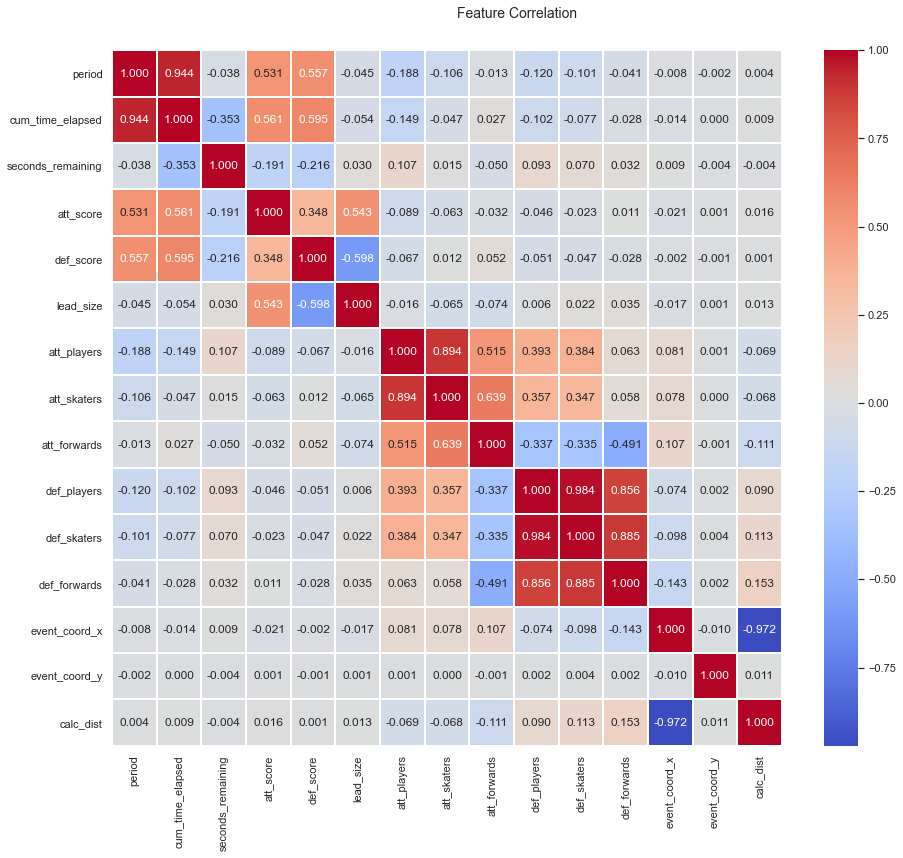

In [58]:
corrmat = shots_df.select_dtypes(include='number').corr();
fig, ax = plt.subplots(figsize=(15, 12));
hm = sns.heatmap(round(corrmat,3), annot=True, ax=ax, cmap="coolwarm",fmt='.3f', linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Feature Correlation', fontsize=14);

There is nothing here that couldn't have been anticipated from knowledge of how fields are defined and the rules of the game. For example, periods are 20 minutes in length, so the high correlation between `period` and `cum_time_elapsed` is expected. Less obvious, but still a consequence of rules, are the negative correlations between the time and player count fields. This is because regular season overtimes are generally played 3-on-3 with 4 players / 3 skaters per team. This rule began in the 2015-16 season. Prior to that, regular season overtimes involved 4-on-4 play.

There is a strategic consideration that shows here. The field `lead_size` has a small negative correlation with `att_skaters` and `att_forwards` which has no symmetric correspondent in the defending team fields. This would reflect the strategic choice for the trailing team to pull their goalie for an extra attacker late in games.

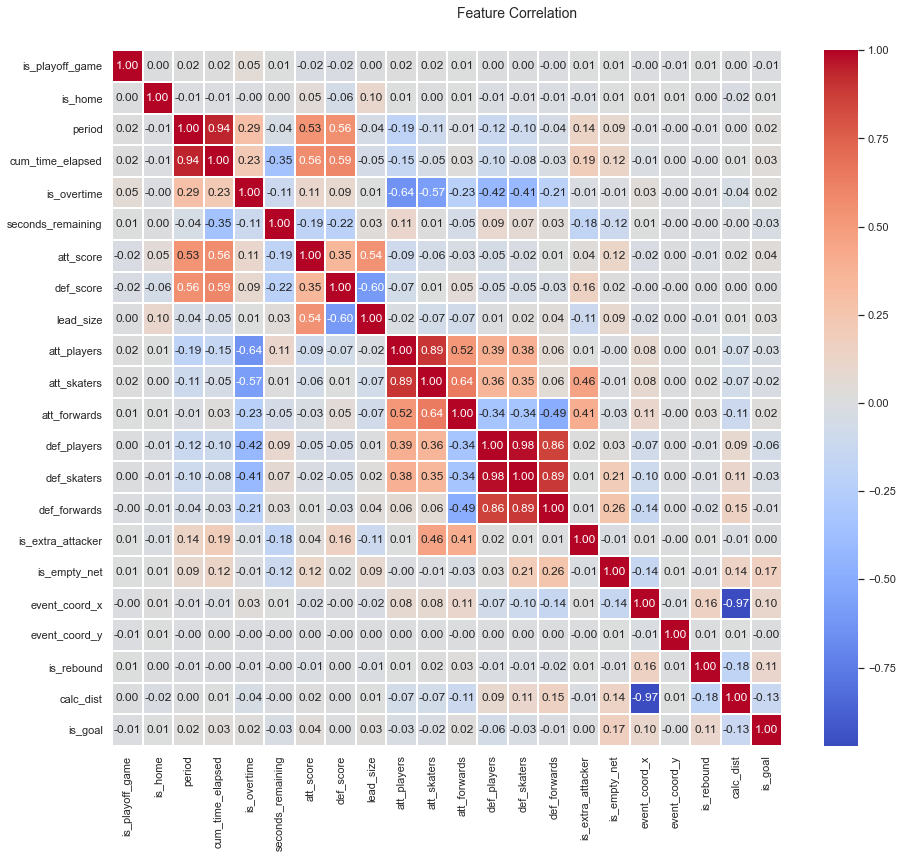

In [59]:
corrmat = shots_df.corr();
fig, ax = plt.subplots(figsize=(15, 12));
hm = sns.heatmap(round(corrmat,3), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Feature Correlation', fontsize=14);

The correlation between `is_overtime` and `lead_size` should be perfectly 0, as `lead_size` should always be 0 in overtime. Overtimes in the NHL are sudden-death, where the first goal ends the game. Investigating this finds there are a handful of cases  which all seem to be a result of the play ordering placing the goal before shots leading to a rebound. There are few enough of these that it shouldn't be an issue.

In [60]:
shots_df[shots_df.is_overtime].lead_size.value_counts()

0    1700
Name: lead_size, dtype: int64

In [61]:
shots_df.reset_index(drop=True, inplace=True)
shots_df[(shots_df.is_overtime) & (shots_df.lead_size > 0)]

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,event_coord_x,event_coord_y,is_rebound,calc_dist,result,is_goal


In [62]:
pd.concat([shots_df[25565:25567], shots_df[327884:327886], shots_df[1102635:1102637]])

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,event_coord_x,event_coord_y,is_rebound,calc_dist,result,is_goal
25565,2018020291,20182019,False,Honda Center,ANA,TOR,True,3,2565,False,1035,EV,1,1,0,MISS,6,5,3,6,5,3,False,False,Off. Zone,Wrist,51.0,21.0,True,43.416587,Wide of Net,False
25566,2018020291,20182019,False,Honda Center,ANA,TOR,True,3,2644,False,956,EV,1,1,0,MISS,6,5,3,6,5,3,False,False,Off. Zone,Wrist,40.0,31.0,False,57.982756,Wide of Net,False


In [63]:
img = mpimg.imread('NHL_Hockey_Rink.png')

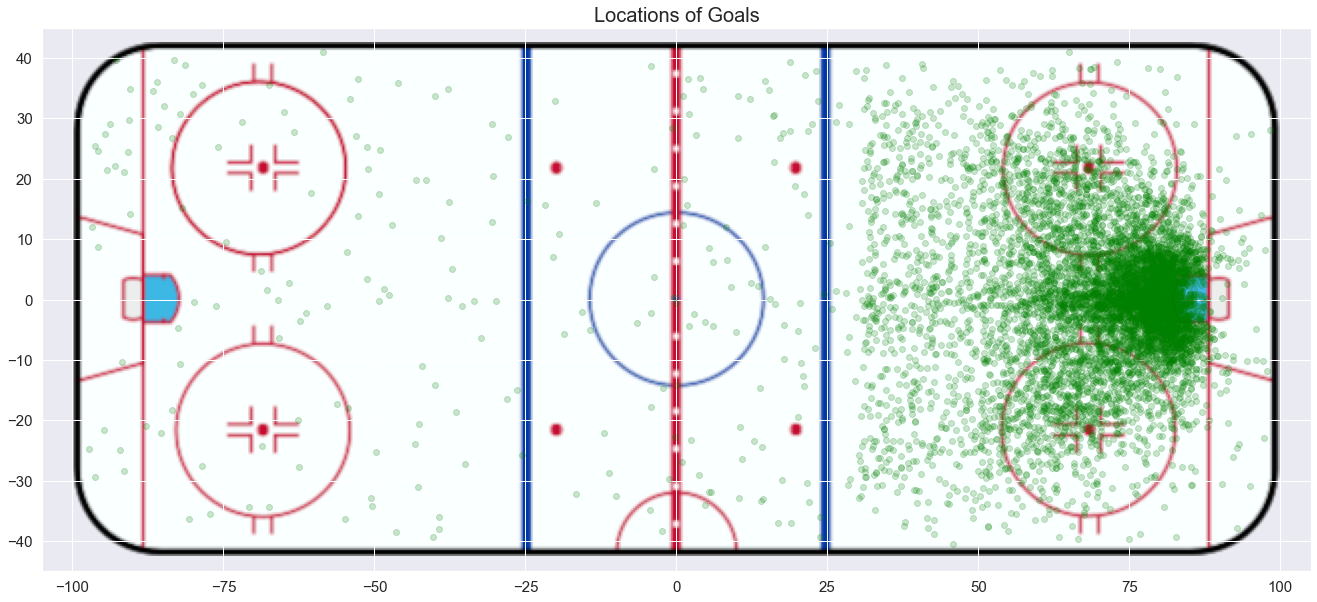

In [64]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where(shots_df['is_goal']==True,shots_df['event_coord_x'],None), 
            y=np.where(shots_df['is_goal']==True,shots_df['event_coord_y'],None), 
            c='green', alpha=0.2, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals', fontsize=20);

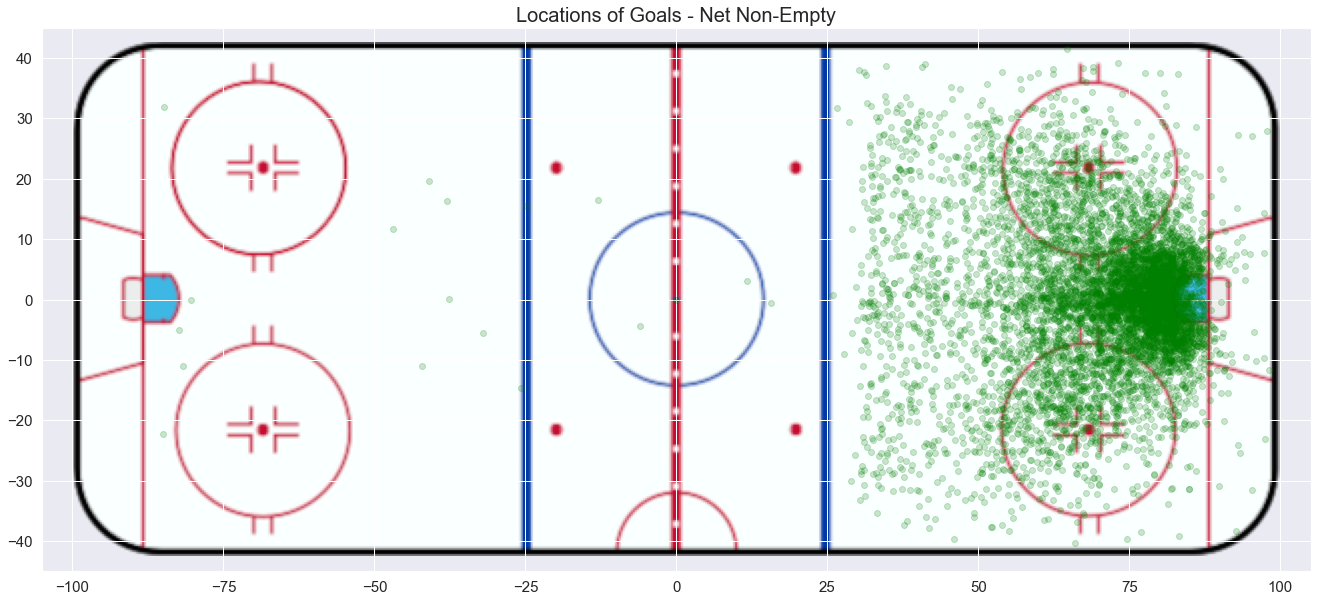

In [65]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==False),shots_df['event_coord_x'],None), 
            y=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==False),shots_df['event_coord_y'],None), 
            c='green', alpha=0.2, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Non-Empty', fontsize=20);

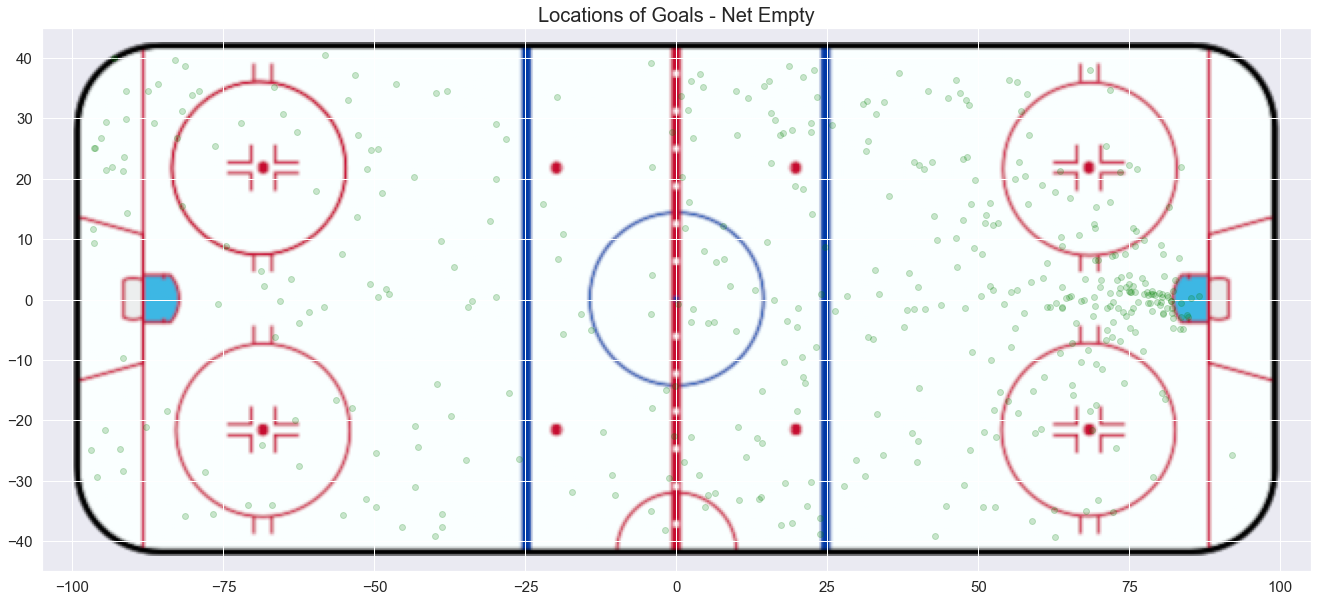

In [66]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==True),shots_df['event_coord_x'],None), 
            y=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==True),shots_df['event_coord_y'],None), 
            c='green', alpha=0.2, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Empty', fontsize=20);

As stated earlier, it is clear that shots are more likely to be successful when taken with fewer defenders on the ice. This is particularly clear when removing empty net shot attempts from consideration.

In [67]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], values='is_goal', aggfunc=['count', 'sum', 'mean'])

count     sum      mean
                        is_goal is_goal   is_goal
att_skaters def_skaters                          
3           3              1191     156  0.130982
            4                12       2  0.166667
            5                 9       1  0.111111
4           3               227      34  0.149780
            4              1357     113  0.083272
            5              3012     210  0.069721
            6                47      31  0.659574
5           3               447      74  0.165548
            4             15172    1436  0.094648
            5             93854    5421  0.057760
            6               638     392  0.614420
6           3                 4       1  0.250000
            4               243      20  0.082305
            5              2055     153  0.074453

In [68]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index=['att_skaters', 'def_skaters'], values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

count     sum      mean
                        is_goal is_goal   is_goal
att_skaters def_skaters                          
3           3              1191     156  0.130982
            4                12       2  0.166667
            5                 8       0  0.000000
4           3               227      34  0.149780
            4              1357     113  0.083272
            5              3007     208  0.069172
5           3               447      74  0.165548
            4             15172    1436  0.094648
            5             93834    5408  0.057634
6           3                 4       1  0.250000
            4               243      20  0.082305
            5              2055     153  0.074453

In [69]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index=['def_skaters'], values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
def_skaters,,,
3,1869,265,0.141787
4,16784,1571,0.093601
5,98904,5769,0.058329


In [70]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="mean")

period                          1         2         3         4         5
att_skaters def_skaters                                                  
3           3                 NaN  1.000000       NaN  0.130252       NaN
            4            0.000000       NaN  0.000000  0.285714       NaN
            5            0.000000  0.000000  0.250000       NaN       NaN
4           3            0.210526  0.048780  0.352941  0.146667       NaN
            4            0.082111  0.093690  0.075515  0.053571       NaN
            5            0.063043  0.071832  0.072941  0.000000  1.000000
            6                 NaN       NaN  0.659574       NaN       NaN
5           3            0.154930  0.182353  0.151515  0.333333       NaN
            4            0.095268  0.095536  0.092756  0.000000  0.333333
            5            0.056137  0.060094  0.057047  0.048780  0.057143
            6                 NaN       NaN  0.614420       NaN       NaN
6           3                 NaN       NaN  0.250000       NaN       NaN
            4            0.000000  0.000000  0.087719       NaN       NaN
            5            0.084615  0.132867  0.068501  1.000000       NaN

In [71]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="count")

period                         1        2        3       4     5
att_skaters def_skaters                                         
3           3                NaN      1.0      NaN  1190.0   NaN
            4                4.0      NaN      1.0     7.0   NaN
            5                3.0      2.0      4.0     NaN   NaN
4           3               19.0     41.0     17.0   150.0   NaN
            4              341.0    523.0    437.0    56.0   NaN
            5              920.0   1239.0    850.0     2.0   1.0
            6                NaN      NaN     47.0     NaN   NaN
5           3              142.0    170.0    132.0     3.0   NaN
            4             4818.0   5914.0   4431.0     6.0   3.0
            5            32118.0  32216.0  29239.0   246.0  35.0
            6                NaN      NaN    638.0     NaN   NaN
6           3                NaN      NaN      4.0     NaN   NaN
            4                8.0      7.0    228.0     NaN   NaN
            5              130.0    143.0   1781.0     1.0   NaN

In [72]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="sum")

period                        1       2       3      4    5
att_skaters def_skaters                                    
3           3               NaN     1.0     NaN  155.0  NaN
            4               0.0     NaN     0.0    2.0  NaN
            5               0.0     0.0     1.0    NaN  NaN
4           3               4.0     2.0     6.0   22.0  NaN
            4              28.0    49.0    33.0    3.0  NaN
            5              58.0    89.0    62.0    0.0  1.0
            6               NaN     NaN    31.0    NaN  NaN
5           3              22.0    31.0    20.0    1.0  NaN
            4             459.0   565.0   411.0    0.0  1.0
            5            1803.0  1936.0  1668.0   12.0  2.0
            6               NaN     NaN   392.0    NaN  NaN
6           3               NaN     NaN     1.0    NaN  NaN
            4               0.0     0.0    20.0    NaN  NaN
            5              11.0    19.0   122.0    1.0  NaN

Most of the larger probabilities by period are a function of the event rarely happening. It does seem intriguing that 5-on-5 goals seem to be more common in the second period than in the first or third.

In [85]:
count = np.array([1803, 1936])
nobs = np.array([32188, 32216])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of 5-on-5 goals, first vs. second periods; p = {pval:0.3f}')

Likelihood of 5-on-5 goals, first vs. second periods; p = 0.027


In [86]:
count = np.array([1936, 1668])
nobs = np.array([32216, 29239])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of 5-on-5 goals, second vs. third periods; p = {pval:0.3f}')

Likelihood of 5-on-5 goals, second vs. third periods; p = 0.108


It seems that the difference between periods is statistically significant. This is something that could be investigated further. There are rule-based reasons why second-period goals may be more likely. In particular, the teams change sides between periods. In the second period, goaltenders are further from their team's bench than in the first period. This makes it more difficult to make substitutions without allowing a scoring chance.

In [75]:
road_v_home = pd.pivot_table(shots_df, index='is_home', values='is_goal', aggfunc=['count', 'sum', 'mean'])
road_shots = road_v_home.loc[False, 'count']['is_goal']
road_goals = road_v_home.loc[False, 'sum']['is_goal']
home_shots = road_v_home.loc[True, 'count']['is_goal']
home_goals = road_v_home.loc[True, 'sum']['is_goal']
road_v_home

,count,sum,mean
,is_goal,is_goal,is_goal
is_home,,,
False,57675,3821,0.066251
True,60605,4223,0.069681


Home goals are more common than road goals. Again, this can be tested for statistical significance.

In [76]:
count = np.array([home_goals, road_goals])
nobs = np.array([home_shots, road_shots])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of goals, home vs. road team; p = {pval:0.3f}')

Likelihood of goals, home vs. road team; p = 0.019


Again, this is statistically significant, indicating that there is an advantage to playing at home. Some of this is rule-based, as there are rules relating to line changes that favor the home team. Some may be due to the environment as well. Future investigation could examine whether this difference is maintained in neutral ice games, where there are still designated home and visiting teams.

In [87]:
rebounds = pd.pivot_table(shots_df, index='is_rebound', values='is_goal', aggfunc=['count', 'sum', 'mean'])
non_rebound_shots = rebounds.loc[False, 'count']['is_goal']
non_rebound_goals = rebounds.loc[False, 'sum']['is_goal']
rebound_shots = rebounds.loc[True, 'count']['is_goal']
rebound_goals = rebounds.loc[True, 'sum']['is_goal']
rebounds

,count,sum,mean
,is_goal,is_goal,is_goal
is_rebound,,,
False,109470,6560,0.059925
True,8810,1484,0.168445


In [89]:
count = np.array([non_rebound_goals, rebound_goals])
nobs = np.array([non_rebound_shots, rebound_shots])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of goals, non rebound vs. rebound; p = {pval:0.3f}')

Likelihood of goals, non rebound vs. rebound; p = 0.000


Unsurprisingly, there is a major difference between rebound and non-rebound opportunities.

In [78]:
pd.pivot_table(shots_df, index='shot_type', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
shot_type,,,
Backhand,8947,777,0.086845
Deflected,2984,264,0.088472
Slap,18150,783,0.043140
Snap,16075,1191,0.074090
Tip,7981,769,0.096354
Unknown,9,6,0.666667
Wrap,1090,60,0.055046
Wrist,63044,4194,0.066525


There also seems to be a relationship between shot-selection and goals. This is also unsurprising, as slap shots are generally from longer distances while tip-ins are just in front of the net.

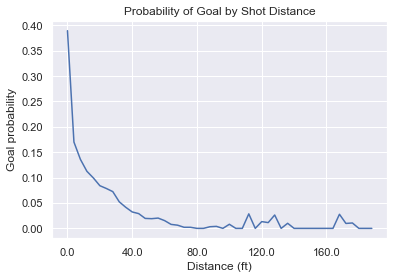

In [79]:
n_bins = 51
no_empty_net = shots_df[~shots_df['is_empty_net']].copy()
no_empty_net['dist_bins'] = pd.cut(no_empty_net['calc_dist'], bins=np.linspace(0, 200, n_bins))
dist_probs = pd.pivot_table(no_empty_net, index='dist_bins', values='is_goal', aggfunc=('count','sum','mean')).reset_index()
dist_probs['mark'] = dist_probs.dist_bins.apply(lambda x: x.left)
dist_probs.plot(x='mark', y='mean', title='Probability of Goal by Shot Distance', \
                xlabel='Distance (ft)', ylabel= 'Goal probability', legend=False);

There seems to be a near-exponential decline in likelihood of scoring goals as shots are taken further from the net.

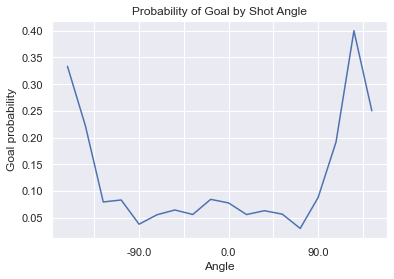

In [80]:
n_bins = 21
no_empty_net['calc_angle'] = np.arctan2(no_empty_net['event_coord_y'], 89 - no_empty_net['event_coord_x']) * 180 / np.pi
no_empty_net['angle_bins'] = pd.cut(no_empty_net['calc_angle'], bins=np.linspace(-180, 180, n_bins))
angle_probs = pd.pivot_table(no_empty_net, index='angle_bins', values='is_goal', aggfunc=('count','sum','mean')).reset_index()
angle_probs['mark'] = angle_probs.angle_bins.apply(lambda x: x.left)
angle_probs.plot(x='mark', y='mean', title='Probability of Goal by Shot Angle', \
                xlabel='Angle', ylabel= 'Goal probability', legend=False);

It appears that shots taken from extreme angles are actually more likely to result in goals. This is something that might be good to research further in the future.

In [81]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='att_forwards', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
att_forwards,,,
1,46,6,0.130435
2,5881,498,0.084679
3,96599,5662,0.058613
4,14089,1366,0.096955
5,931,72,0.077336
6,11,1,0.090909


The number of forwards doesn't appear to have an obvious relation to the likelihood of scoring.

In [82]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='is_extra_attacker', values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
is_extra_attacker,,,
False,115181,7425,0.064464
True,2388,180,0.075377


There is a possible relationship between extra attackers and goals. This is what would be expected according to conventional wisdom.

In [83]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='event_zone', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
event_zone,,,
Def. Zone,1760,13,0.007386
Neu. Zone,3305,7,0.002118
Off. Zone,112504,7585,0.067420


Unsurprisingly, the likelihood of scoring decreases substantially for shots taken outside the offensive zone. The increase in successful shots from the defensive zone was unexpected. This also suggests a future research direction.

In [84]:
ADJUSTED_DATAFRAME_FILE = DATA_FOLDER + 'adjusted_cleaned_data.pkl'
current_dir = Path.cwd()
frame_path = current_dir.joinpath(ADJUSTED_DATAFRAME_FILE)
shots_df.to_pickle(str(frame_path))